In [1]:
# -*- coding: utf-8 -*-
# """
# Created on Wed Sep  9 09:44:11 2020
# @author: Trevor
# """
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from astropy.stats import sigma_clip
from scipy import optimize, signal
import pickle
import warnings
warnings.filterwarnings("ignore")

def wfc3_extract(hist_med, plnm='W79', numxaps=5, numyaps=10):

#---Working Directory----------------------------------------------   
   # fpath = '/Users/mauralally/Desktop/HST_project/' 
   # filenames = glob.glob(fpath + 'LTT1445_test/' + '*flt_test.fits')
   # filenames = sorted(filenames)
    fpath='/Users/fixit/Desktop/Python/Research/'
    filenames = glob.glob(fpath +'/LTT1445_fits_files/'+ '/Test/'+'/Tes2/'+'*flt.fits')
    filenames = sorted(filenames)
#---LOOP OVER EACH FITS FILE---------------------------------------
    
    for i in range(0, len(filenames)):
        hdulist = fits.open(filenames[i])

#-------make the arrays we will need-------------------------------
        if i == 0:
            img_ax = np.asarray(hdulist[1].data)
            subarray=len(img_ax)
            subarray2 = len(img_ax[0])
            nsamp=1
            print (str(len(filenames))+'files and'+str(nsamp)+'samples each')
            nsamp=int(nsamp)
            temp=np.zeros(shape=(subarray, subarray2))
            images=np.zeros(shape=(subarray, subarray2, len(filenames)))
            time=np.zeros(len(filenames))
            raDeg=np.zeros(len(filenames))
            decDeg=np.zeros(len(filenames))
            wlc=np.zeros(shape=(len(filenames), numyaps, numxaps))
            scan_ang=np.zeros(len(filenames))
            ndrwhite=np.zeros(shape=(numyaps, numxaps))  
            flux=np.zeros(shape=(numyaps, numxaps))
            error=np.zeros(shape=(numyaps, numxaps))
            diff=np.zeros(shape=(numyaps, numxaps))
            wlc_error=np.zeros(shape=(len(filenames), numyaps, numxaps))
        else: 
            pass
                    
#-------get info from headers----------------------------------------
        scidata=hdulist[1].data
        err=hdulist[2].data
        
        expstart=hdulist[0].header['EXPSTART']
        expend=hdulist[0].header['EXPEND']
        exptime=hdulist[0].header['EXPTIME']
        scan_ang[i]=hdulist[0].header['SCAN_ANG']
        scanlen=hdulist[0].header[ 'SCAN_LEN']
        raDeg = hdulist[0].header['RA_TARG']
        decDeg = hdulist[0].header['DEC_TARG']
        time[i]=0.5*(expend+expstart)
        if i ==0:
            xybox=getbox(scidata) #THIS GETS A BOX THE SIZE OF THE SPEC
            x_range=xybox[1]+1-xybox[0]
            y_range=xybox[3]+1-xybox[2]
            x_cen=np.floor((xybox[1]+1-xybox[0])/2.)
            y_cen=np.floor((xybox[3]+1-xybox[2])/2.)
            
            xybox2=getbox2(scidata) #THIS GETS A BOX THE SIZE OF THE SPEC
            x_range2=xybox2[1]+1-xybox2[0]
            y_range2=xybox2[3]+1-xybox2[2]
            x_cen2=np.floor((xybox2[1]+1-xybox2[0])/2.)
            y_cen2=np.floor((xybox2[3]+1-xybox2[2])/2.)

            xybox3=getbox3(scidata) #THIS GETS A BOX THE SIZE OF THE SPEC
            x_range3=xybox3[1]+1-xybox3[0]
            y_range3=xybox3[3]+1-xybox3[2]
            x_cen3=np.floor((xybox3[1]+1-xybox3[0])/2.)
            y_cen3=np.floor((xybox3[3]+1-xybox3[2])/2.)
            
#-------flat field and background--------------------------------------
        scidata, images = background_and_flat(scidata, images, hist_med, i)
    
        for aprx in range(0, numxaps):
            xwidth=x_range+aprx
           # xwidth2=x_range2+aprx
            
            for apry in range(0, numyaps):
# #                 ff=np.sum(scidata[xybox[2]-apry:xybox[3]+1+apry, xybox[0]-aprx:xybox[1]+1+aprx])
                er=np.sum(err[xybox[2]-apry:xybox[3]+1+apry, xybox[0]-aprx:xybox[1]+1+aprx]**2.)
              #  er2=np.sum(err[xybox2[2]-apry:xybox2[3]+1+apry, xybox2[0]-aprx:xybox2[1]+1+aprx]**2.)
#                 flux[apry, aprx] = wlc
                error[apry, aprx]=er
        wlc_error[i,:,:]=np.sum(error, axis=0)**0.5
        diff=np.zeros(shape=(numyaps, numxaps))
        wlc[i, :, :]=diff
        
    print('wlc', wlc)
    plt.figure()
    plt.errorbar(time,  wlc[:,0,0], yerr=wlc_error[:,0,0], fmt='o', color='k')
    plt.xlabel('Time ($MJD_{UTC}$)')
    plt.ylabel('Flux (e$^-$)')
    plt.title('WFC3 Raw Light curve')
    plt.show()
    
   # outpath = fpath+'LTT1445_outpath/'
   # fileObject = open(outpath+'wlc_extract_out', 'wb')
   # pickle.dump([time, wlc, wlc_error, raDeg, decDeg, scidata, 
    #             xybox], fileObject)
    #fileObject.close()
    
    return time, wlc, wlc_error, raDeg, decDeg, scidata, xybox


def background_and_flat(scidata, images, hist_med, i):
#---define columns at the edge of the image to mask--------------------------------
#     cols1 = np.arange(0,50)
#     cols2 = np.arange(450, 512)
#     edges=np.append(cols1,cols2)
#     m = np.zeros_like(scidata)
#     m[:,edges] = 1
#     m[edges, :] = 1
#     scidata=np.ma.masked_array(scidata, m)         
#---get rid of cosmic rays---------------------------------------------------------
    scidata = sigma_clip(scidata, sigma=7)
#---background box-----------------------------------------------------------------
#     backbox=scidata[xybox[2]-100:xybox[2]-50, :]
#     backbox=scidata[xybox[3]+50:xybox[3]+100, :] #pulling bg in form scidata[ymin, ymax, xmin, xmax]
   
#     bkgd = backbox.mean(axis=0)
#     print('background',bkgd)
#     bkgd = sp.signal.medfilt(bkgd,31)
#     bkgd = np.array([bkgd,]*522)
    bkgd = hist_med #set this as the median from the histogram for bkgrd
    
    scidata = scidata-bkgd
    print('scidata - bkgd', scidata)
#     scidata = sigma_clip(scidata, sigma=5)
#     print('scidata shape:', np.shape(scidata))
#     print('images shape:', np.shape(images))
#     print('images_section shape:', np.shape(images[:,:,j,i]))
    images[:,:,i]=scidata


    return scidata, images

### Finds 1st order 
def getbox(scidata):
    #box1 = [80,180,300,400,400,300,512,400]
    #box1 = [xmin,xmax,yminbot,ymaxbot,ymintop,ymaxtop]
    box1 = [80,500,300,400,400,300,512,440]
    tried = 1
    holdy=np.zeros(100)
    holdx=np.zeros(100)
    for xx in range(box1[0],box1[1],10): #CHANGE the 80 & 180 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
        for yy in range(box1[2],box1[3]): #CHANGE the 0 & 250 to span pixels that are on
                                #either side of the bottom edge of your spectra
                                #without encompassing contamination sources
            ybot=yy
            if scidata[yy,xx] > 4*np.mean(scidata):
                break
        holdy[int((xx-box1[0])/10-1)]=ybot #CHANGE 80 to min value chosen for xx
    holdy = np.array(list(filter(lambda num: num != 0, holdy)))
    ybot=int(np.median(holdy))
    
    for xx in range(box1[0],box1[1],10): #CHANGE the 80 & 180 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
        for yy in range(box1[4],box1[5], -1): #CHANGE the 450 & 0 to span pixels that are 
                                #on either side of the top edge of your spectra
                                #without encompassing contamination sources
            ytop=yy
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        holdy[int((xx-box1[0])/10-1)]=ytop #CHANGE 80 to min value chosen for xx
    holdy = np.array(list(filter(lambda num: num != 0, holdy)))
    ytop=int(np.median(holdy))

    #for yy in range(ybot,ytop, tried):
    for yy in range(345,355, tried):
        for xx in range(box1[0],box1[1]): #CHANGE the 0 & 350 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
            xleft=xx
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        #holdx[int((yy-ybot)/(tried)-1)]=xleft
        holdx[int((yy-345)/(tried)-1)]=xleft
    holdx = np.array(list(filter(lambda num: num != 0, holdx)))
    xleft=int(np.median(holdx))
    #for yy in range(ybot,ytop, tried):
    for yy in range(345,355, tried):
        for xx in range(box1[6],box1[7], -1): #CHANGE the 250 & 0 to span pixels that are on 
                                #either side of the right edge of your spectra 
                                #without encompassing contamination sources
            xright=xx
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        #holdx[int((yy-ybot)/(1)-tried)]=xright
        holdx[int((yy-345)/(1)-tried)]=xright
    holdx = np.array(list(filter(lambda num: num != 0, holdx)))
    xright=int(np.median(holdx))
    global xybox
    xybox=np.array([xleft, xright, ybot, ytop])

    print('xybox(xleft, xright, ybot, ytop)=', xybox)
    return xybox
#---------------------------------------------------------------------------
#---2nd box-----------------------------------------------------------------
#----------------------------------------------------------------------------
def getbox2(scidata):
    box2 = [50,440,180,200,200,180,450,370]
    tried = 1
    holdy=np.zeros(100)
    holdx=np.zeros(100)
    for xx in range(box2[0],box2[1],10): #CHANGE the 80 & 180 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
        for yy in range(box2[2],box2[3]): #CHANGE the 0 & 250 to span pixels that are on
                                #either side of the bottom edge of your spectra
                                #without encompassing contamination sources
            ybot=yy
            if scidata[yy,xx] > 4*np.mean(scidata):
                break
        holdy[int((xx-box2[0])/10-1)]=ybot #CHANGE 80 to min value chosen for xx
    holdy = np.array(list(filter(lambda num: num != 0, holdy)))
    ybot=int(np.median(holdy))
    
    for xx in range(box2[0],box2[1],10): #CHANGE the 80 & 180 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
        for yy in range(box2[4],box2[5], -1): #CHANGE the 450 & 0 to span pixels that are 
                                #on either side of the top edge of your spectra
                                #without encompassing contamination sources
            ytop=yy
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        holdy[int((xx-box2[0])/10-1)]=ytop #CHANGE 80 to min value chosen for xx
    holdy = np.array(list(filter(lambda num: num != 0, holdy)))
    ytop=int(np.median(holdy))

    #for yy in range(ybot,ytop, tried):
    for yy in range(185,195, tried):
        for xx in range(box2[0],box2[1]): #CHANGE the 0 & 350 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
            xleft=xx
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        #holdx[int((yy-ybot)/(tried)-1)]=xleft
        holdx[int((yy-185)/(tried)-1)]=xleft
    holdx = np.array(list(filter(lambda num: num != 0, holdx)))
    xleft=int(np.median(holdx))
    #for yy in range(ybot,ytop, tried):
    for yy in range(185,195, tried):
        for xx in range(box2[6],box2[7], -1): #CHANGE the 250 & 0 to span pixels that are on 
                                #either side of the right edge of your spectra 
                                #without encompassing contamination sources
            xright=xx
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        #holdx[int((yy-ybot)/(1)-tried)]=xright
        holdx[int((yy-185)/(1)-tried)]=xright
    holdx = np.array(list(filter(lambda num: num != 0, holdx)))
    xright=int(np.median(holdx))
    global xybox2
    xybox2=np.array([xleft, xright, ybot, ytop])

    print('xybox2(xleft2, xright2, ybot2, ytop2)=', xybox2)
    return xybox2
#---------------------------------------------------------------------------
#---3rd box-----------------------------------------------------------------
#----------------------------------------------------------------------------
def getbox3(scidata):
    box3 = [45,430,145,180,180,145,440,360]
    tried = 1
    holdy=np.zeros(100)
    holdx=np.zeros(100)
    for xx in range(box3[0],box3[1],10): #CHANGE the 80 & 180 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
        for yy in range(box3[2],box3[3]): #CHANGE the 0 & 250 to span pixels that are on
                                #either side of the bottom edge of your spectra
                                #without encompassing contamination sources
            ybot=yy
            if scidata[yy,xx] > 4*np.mean(scidata):
                break
        holdy[int((xx-box3[0])/10-1)]=ybot #CHANGE 80 to min value chosen for xx
    holdy = np.array(list(filter(lambda num: num != 0, holdy)))
    ybot=int(np.median(holdy))
    
    for xx in range(box3[0],box3[1],10): #CHANGE the 80 & 180 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
        for yy in range(box3[4],box3[5], -1): #CHANGE the 450 & 0 to span pixels that are 
                                #on either side of the top edge of your spectra
                                #without encompassing contamination sources
            ytop=yy
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        holdy[int((xx-box3[0])/10-1)]=ytop #CHANGE 80 to min value chosen for xx
    holdy = np.array(list(filter(lambda num: num != 0, holdy)))
    ytop=int(np.median(holdy))

    #for yy in range(ybot,ytop, tried):
    for yy in range(155,170, tried):
        for xx in range(box3[0],box3[1]): #CHANGE the 0 & 350 to span pixels that are on 
                                #either side of the left edge of your spectra 
                                #without encompassing contamination sources
            xleft=xx
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        #holdx[int((yy-ybot)/(tried)-1)]=xleft
        holdx[int((yy-155)/(tried)-1)]=xleft
    holdx = np.array(list(filter(lambda num: num != 0, holdx)))
    xleft=int(np.median(holdx))
    #for yy in range(ybot,ytop, tried):
    for yy in range(155,170, tried):
        for xx in range(box3[6],box3[7], -1): #CHANGE the 250 & 0 to span pixels that are on 
                                #either side of the right edge of your spectra 
                                #without encompassing contamination sources
            xright=xx
            if scidata[yy,xx] > 2*np.mean(scidata):
                break
        #holdx[int((yy-ybot)/(1)-tried)]=xright
        holdx[int((yy-155)/(1)-tried)]=xright
    holdx = np.array(list(filter(lambda num: num != 0, holdx)))
    xright=int(np.median(holdx))
    global xybox3
    xybox3=np.array([xleft, xright, ybot, ytop])

    print('xybox3(xleft3, xright3, ybot3, ytop3)=', xybox3)
    return xybox3

1files and1samples each
xybox(xleft, xright, ybot, ytop)= [126 502 345 355]
xybox2(xleft2, xright2, ybot2, ytop2)= [ 61 437 188 196]
xybox3(xleft3, xright3, ybot3, ytop3)= [ 54 423 160 166]
scidata - bkgd [[-12059.3671875 -12059.0546875 -12055.7333984375 ... -12059.759765625
  -12059.5810546875 -12058.8095703125]
 [-12069.10546875 -12059.751953125 -12049.5400390625 ...
  -12054.8447265625 -12066.7119140625 -12064.05859375]
 [-12058.4873046875 -12050.3330078125 -12060.357421875 ...
  -12056.3876953125 -12059.22265625 -12055.353515625]
 ...
 [-12058.0859375 -12060.7041015625 -12063.3984375 ... -12051.3330078125
  -12064.6552734375 -12059.013671875]
 [-12060.3291015625 -12055.7861328125 -12060.67578125 ...
  -12059.990234375 -12059.7314453125 -12055.2900390625]
 [-12062.2216796875 -12057.4892578125 -12054.9140625 ... -12059.93359375
  -12053.4169921875 -12057.9560546875]]
wlc [[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]


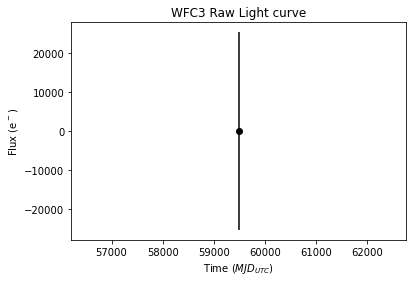

In [2]:
from astropy.utils.data import get_pkg_data_filename
fpath='/Users/fixit/Desktop/Python/Research/LTT1445_fits_files/Test/Tes2/'
mist = glob.glob(fpath+'*.fits')
mist = sorted(mist)
image_file = get_pkg_data_filename(mist[0])
image_data = fits.getdata(image_file, ext=0)
x = np.zeros(len(image_data))
for n in range(len(image_data)):
    x[n] = np.sum(image_data[n][:])
hist_med = np.median(x)

MJD_UTC, flux, flux_err, raDeg, decDeg, scidata, xybox = wfc3_extract(hist_med)
# BJD_TDB_f = mjd_bjd.mjd_bjd(MJD_UTC, flux, flux_err, raDeg, decDeg)

(126, 345) 376 10
xybox(xleft, xright, ybot, ytop)= [ 80 512 300 400]
[ 80 512 300 400]


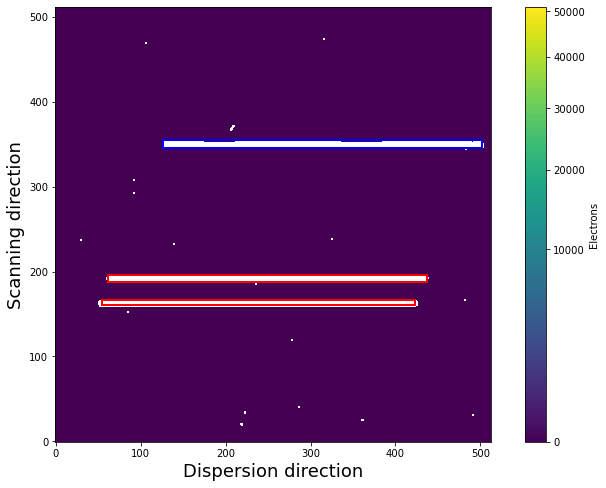

In [3]:
###View NDR of first image of first visit
from astropy.visualization import simple_norm
import matplotlib.patches as patches
# Create an ImageNormalize object
norm = simple_norm(scidata, 'sqrt', min_cut=0)


# Display the image

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(scidata, origin='lower', norm=norm)

#First order spectra search
rect1 = patches.Rectangle((xybox[0],xybox[2]),(xybox[1]-xybox[0]),(xybox[3]-xybox[2]), 
                          fill=False, ec='b', linewidth=2)
# rect2 = patches.Rectangle((60,185),(380),(10), fill=False, ec='r', linewidth=2)
# #Background region
# rect3 = patches.Rectangle((50,155),(380),(10), fill=False, ec='r', linewidth=2)
rect2 = patches.Rectangle((xybox2[0],xybox2[2]),(xybox2[1]-xybox2[0]),(xybox2[3]-xybox2[2]),
                          fill=False, ec='r', linewidth=2)
#Background region
rect3 = patches.Rectangle((xybox3[0],xybox3[2]),(xybox3[1]-xybox3[0]),(xybox3[3]-xybox3[2]),
                           fill=False, ec='r', linewidth=2)

ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)

fig.colorbar(im, label='Electrons')
ax.set_xlabel('Dispersion direction', fontsize=18)
ax.set_ylabel('Scanning direction', fontsize=18)
fig.show()
print((xybox[0],xybox[2]),(xybox[1]-xybox[0]),(xybox[3]-xybox[2]))
print(getbox(scidata))